<a href="https://colab.research.google.com/github/soumik12345/Facial-keypoints-detection/blob/master/facial_keypoints_Mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown https://drive.google.com/uc?id=1U8kYzstRkhrpmmSpOgxp5YfkhFbdqHy7
!unzip -q facial-keypoints-detection.zip

Downloading...
From: https://drive.google.com/uc?id=1U8kYzstRkhrpmmSpOgxp5YfkhFbdqHy7
To: /content/facial-keypoints-detection.zip
86.9MB [00:01, 77.9MB/s]


In [1]:
!pip install -q tensorflow-model-optimization

In [1]:
import os
import cv2
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_model_optimization as tfmot

## Dataset and Preprocessing

In [2]:
train_data = pd.read_csv('./facial-keypoints-detection/training.csv')
test_data = pd.read_csv('./facial-keypoints-detection/test.csv')

print('Original Train Data Size:', len(train_data))
print('Original Test Data Size:', len(test_data))

train_data = train_data.dropna()
test_data = test_data.dropna()

print('Train Data Size after removing Null:', len(train_data))

train_data, val_data = train_test_split(train_data, test_size=0.1, shuffle=True)
print('Effective Train Data Size:', len(train_data))
print('Effective Validation Data Size:', len(val_data))
print('Effective Test Data Size:', len(test_data))

Original Train Data Size: 7049
Original Test Data Size: 1783
Train Data Size after removing Null: 2140
Effective Train Data Size: 1926
Effective Validation Data Size: 214
Effective Test Data Size: 1783


### Rotation Augmentation

In [3]:
def rotate_augmentation(images, keypoints):
    rotated_images, rotated_keypoints, angle = [], [], 12
    for angle in [angle, -angle]:
        M = cv2.getRotationMatrix2D((48, 48), angle, 1.)
        angle_rad = -angle * math.pi / 180.
        for image in images:
            rotated_image = cv2.warpAffine(image, M, (96, 96), flags=cv2.INTER_CUBIC)
            rotated_images.append(rotated_image)
        for keypoint in keypoints:
            rotated_keypoint = keypoint - 48.
            for idx in range(0, len(rotated_keypoint), 2):
                rotated_keypoint[idx] = rotated_keypoint[idx] * math.cos(angle_rad) - rotated_keypoint[idx + 1] * math.sin(angle_rad)
                rotated_keypoint[idx + 1] = rotated_keypoint[idx] * math.sin(angle_rad) + rotated_keypoint[idx + 1] * math.cos(angle_rad)
            rotated_keypoint += 48.   
            rotated_keypoints.append(rotated_keypoint)
    return np.reshape(rotated_images,(-1, 96, 96, 1)), np.array(rotated_keypoints)

### Shift Augmentation

In [4]:
def shift_images(images, keypoints):
    shifted_images, shifted_keypoints, shift = [], [], 12
    for (shift_x, shift_y) in [(-shift, -shift), (-shift, shift), (shift, -shift), (shift, shift)]:
        M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
        for image, keypoint in zip(images, keypoints):
            shifted_image = cv2.warpAffine(image, M, (96, 96), flags=cv2.INTER_CUBIC)
            shifted_keypoint = np.array([(point + shift_x) if idx % 2 == 0 else (point + shift_y) for idx, point in enumerate(keypoint)])
            if np.all(0.0 < shifted_keypoint) and np.all(shifted_keypoint < 96.0):
                shifted_images.append(shifted_image.reshape(96, 96, 1))
                shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints, 0.0, 96.0)
    return np.array(shifted_images), shifted_keypoints

### Dataloader

In [5]:
def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images) / 255.
    return images

def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop(['Image'], axis=1)
    keypoint_features = []
    for idx, features in keypoint_data.iterrows():
        keypoint_features.append(features)
    keypoint_features = np.array(keypoint_features, dtype=float)
    return keypoint_features

In [6]:
def visualize_data(image_data, keypoints, n_rows=4, n_cols=4):
    fig = plt.figure(figsize=(2 * n_cols, 2 * n_cols), dpi=200)
    for i, idx in enumerate(np.random.randint(0, len(keypoints), n_rows * n_cols)):
        axis = fig.add_subplot(n_rows, n_cols, i+1, xticks=[], yticks=[])
        if axis is None:
            fig, axis = plt.subplots()
        axis.scatter(keypoints[idx][0::2], keypoints[idx][1::2], s=8, c='red')
        axis.imshow(image_data[idx].squeeze())
    plt.show()

In [7]:
class FacialKeyPointsDataset(tf.keras.utils.Sequence):

    def __init__(self, data, batch_size=64, apply_augmentations=False):
        
        self.batch_size = batch_size
        self.apply_augmentations = apply_augmentations
        self.images = load_images(data)
        self.keypoints = load_keypoints(data)
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.images) / float(self.batch_size)))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        np.random.shuffle(self.indexes)
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_images = self.images[indexes, ...]
        batch_keypoints = self.keypoints[indexes, :]
        if self.apply_augmentations:
            if random.random() < 0.5:
                batch_images, batch_keypoints = rotate_augmentation(batch_images, batch_keypoints)
            if random.random() < 0.5:
                batch_images, batch_keypoints = shift_images(batch_images, batch_keypoints)
        batch_images = np.concatenate((batch_images, batch_images, batch_images), axis=-1)
        return batch_images, batch_keypoints

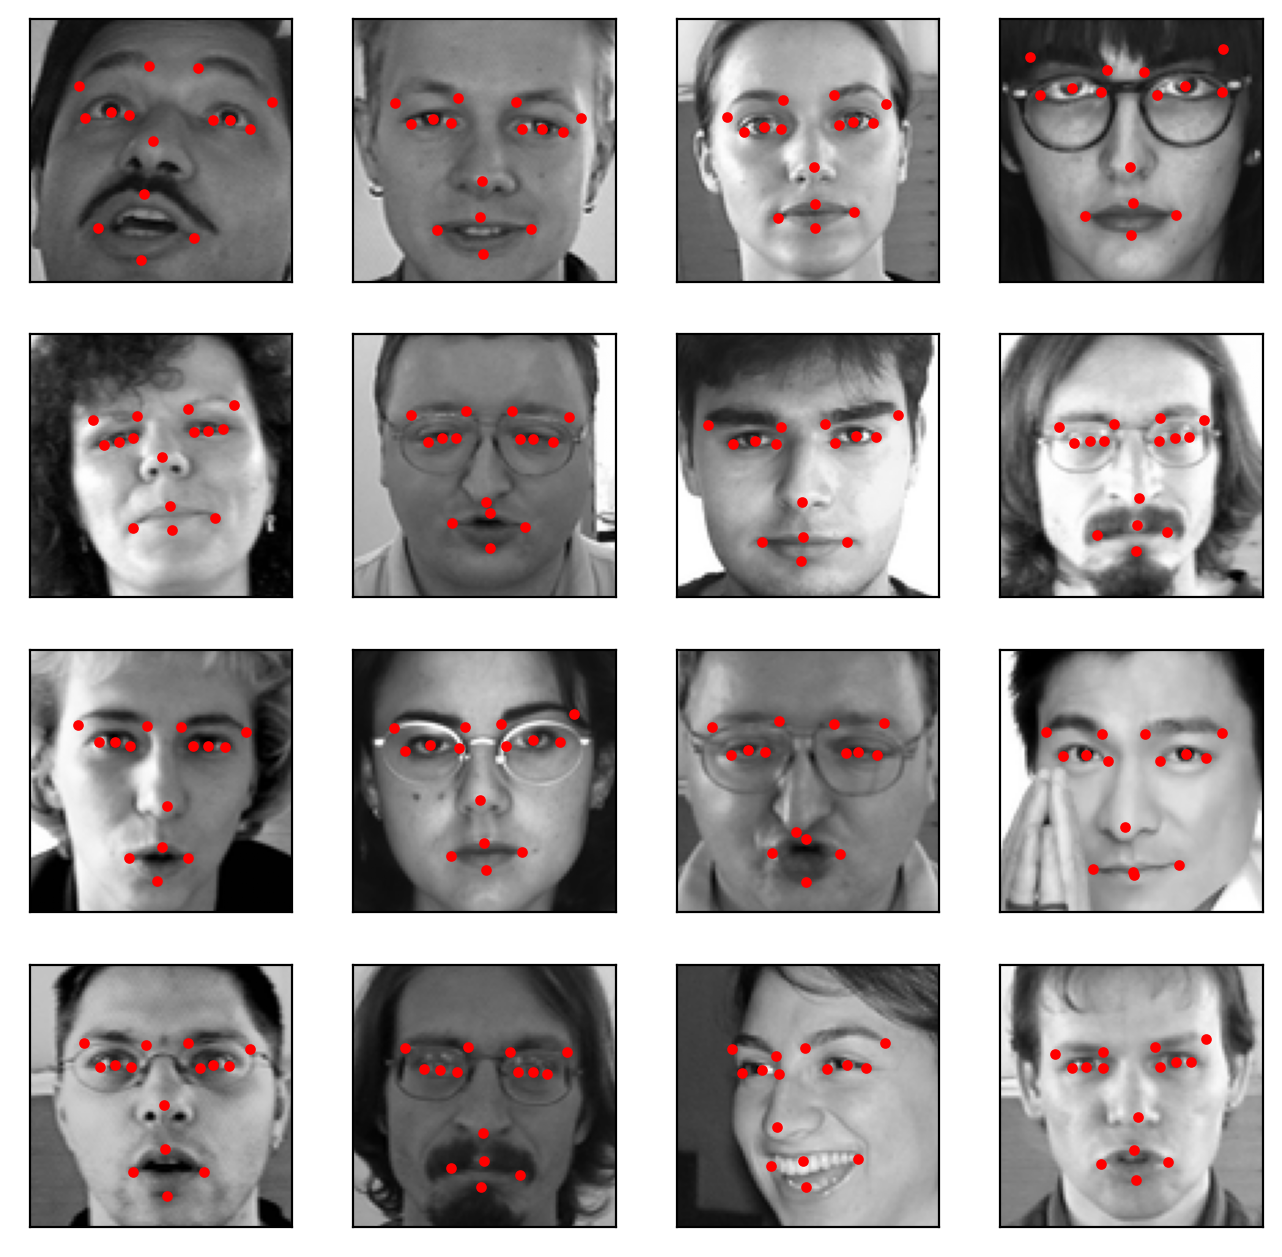

In [8]:
train_dataset = FacialKeyPointsDataset(train_data, apply_augmentations=False)
batch_images, batch_keypoints = train_dataset[0]
visualize_data(batch_images, batch_keypoints, n_rows=4, n_cols=4)

## Model Training

### Training base model

In [9]:
base_model = tf.keras.applications.MobileNet(
    weights="imagenet", include_top=False, input_shape=(96, 96, 3))
base_model.trainable = True

def build_model():
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    outputs = tf.keras.layers.Dense(30)(x)
    return tf.keras.Model(base_model.input, outputs)


model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 48, 48, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 48, 48, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 48, 48, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 48, 48, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 48, 48, 32)        0     

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy']
)

train_dataset = FacialKeyPointsDataset(train_data, batch_size=16, apply_augmentations=True)
val_dataset = FacialKeyPointsDataset(val_data, batch_size=16, apply_augmentations=False)

history = model.fit(
    train_dataset, validation_data=val_dataset,
    epochs=30, batch_size=64, callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'base_model.h5',
            monitor="val_loss",
            save_best_only=True,
        ), tf.keras.callbacks.EarlyStopping(
            monitor='loss', patience=5, mode='min'),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy', factor=0.5,
            patience=5, min_lr=1e-15, mode='max'
        )
    ]
)

Epoch 1/30
121/121 [==============================] - 45s 331ms/step - loss: 153.4921 - accuracy: 0.5280 - val_loss: 1087.1687 - val_accuracy: 0.5467
Epoch 2/30
121/121 [==============================] - 18s 152ms/step - loss: 19.7871 - accuracy: 0.6604 - val_loss: 233.7641 - val_accuracy: 0.4720
Epoch 3/30
121/121 [==============================] - 14s 117ms/step - loss: 15.9949 - accuracy: 0.6962 - val_loss: 30.4027 - val_accuracy: 0.7477
Epoch 4/30
121/121 [==============================] - 13s 111ms/step - loss: 14.8834 - accuracy: 0.6964 - val_loss: 9.1813 - val_accuracy: 0.7664
Epoch 5/30
121/121 [==============================] - 10s 79ms/step - loss: 13.7529 - accuracy: 0.7249 - val_loss: 18.7060 - val_accuracy: 0.7664
Epoch 6/30
121/121 [==============================] - 8s 68ms/step - loss: 11.6687 - accuracy: 0.7151 - val_loss: 16.7533 - val_accuracy: 0.7850
Epoch 7/30
121/121 [==============================] - 8s 68ms/step - loss: 10.1502 - accuracy: 0.7485 - val_loss: 4.71

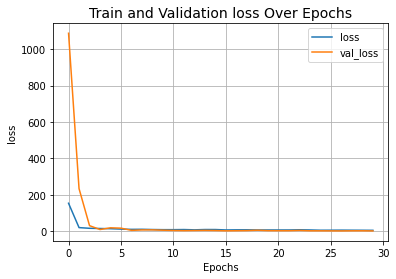

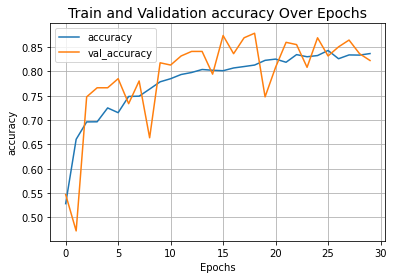

In [11]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [13]:
model = tf.keras.models.load_model('./base_model.h5')
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy']
)
model.evaluate(val_dataset)

14/14 [==============================] - 1s 11ms/step - loss: 1.6076 - accuracy: 0.8224


[1.6076399087905884, 0.822429895401001]

### Fully Quantized Model Training

In [ ]:
fully_quantized_model = tfmot.quantization.keras.quantize_model(model)

fully_quantized_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy']
)

train_dataset = FacialKeyPointsDataset(train_data, batch_size=16, apply_augmentations=True)
val_dataset = FacialKeyPointsDataset(val_data, batch_size=16, apply_augmentations=False)

history = fully_quantized_model.fit(
    train_dataset, validation_data=val_dataset,
    epochs=30, batch_size=64, callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'fully_quantized_model.h5',
            monitor="val_loss",
            save_best_only=True,
        ), tf.keras.callbacks.EarlyStopping(
            monitor='loss', patience=5, mode='min'),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy', factor=0.5,
            patience=5, min_lr=1e-15, mode='max'
        )
    ]
)

Epoch 1/30
121/121 [==============================] - 61s 444ms/step - loss: 1981.8080 - accuracy: 5.3324e-04 - val_loss: 1739.6260 - val_accuracy: 0.0000e+00
Epoch 2/30
121/121 [==============================] - 31s 249ms/step - loss: 1611.5334 - accuracy: 0.0000e+00 - val_loss: 1387.2710 - val_accuracy: 0.0000e+00
Epoch 3/30
121/121 [==============================] - 22s 181ms/step - loss: 1286.1400 - accuracy: 0.0000e+00 - val_loss: 1085.2114 - val_accuracy: 0.0000e+00
Epoch 4/30
121/121 [==============================] - 24s 196ms/step - loss: 998.0774 - accuracy: 0.0000e+00 - val_loss: 765.5543 - val_accuracy: 0.0000e+00
Epoch 5/30
121/121 [==============================] - 23s 193ms/step - loss: 613.0768 - accuracy: 5.3116e-04 - val_loss: 376.8754 - val_accuracy: 0.0000e+00
Epoch 6/30
121/121 [==============================] - 25s 210ms/step - loss: 278.3965 - accuracy: 0.0017 - val_loss: 200.3184 - val_accuracy: 0.0000e+00
Epoch 7/30
 40/121 [========>.....................] - ET

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [ ]:
fully_quantized_model = tf.keras.models.load_model('./fully_quantized_model.h5')
fully_quantized_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy']
)
fully_quantized_model.evaluate(val_dataset)

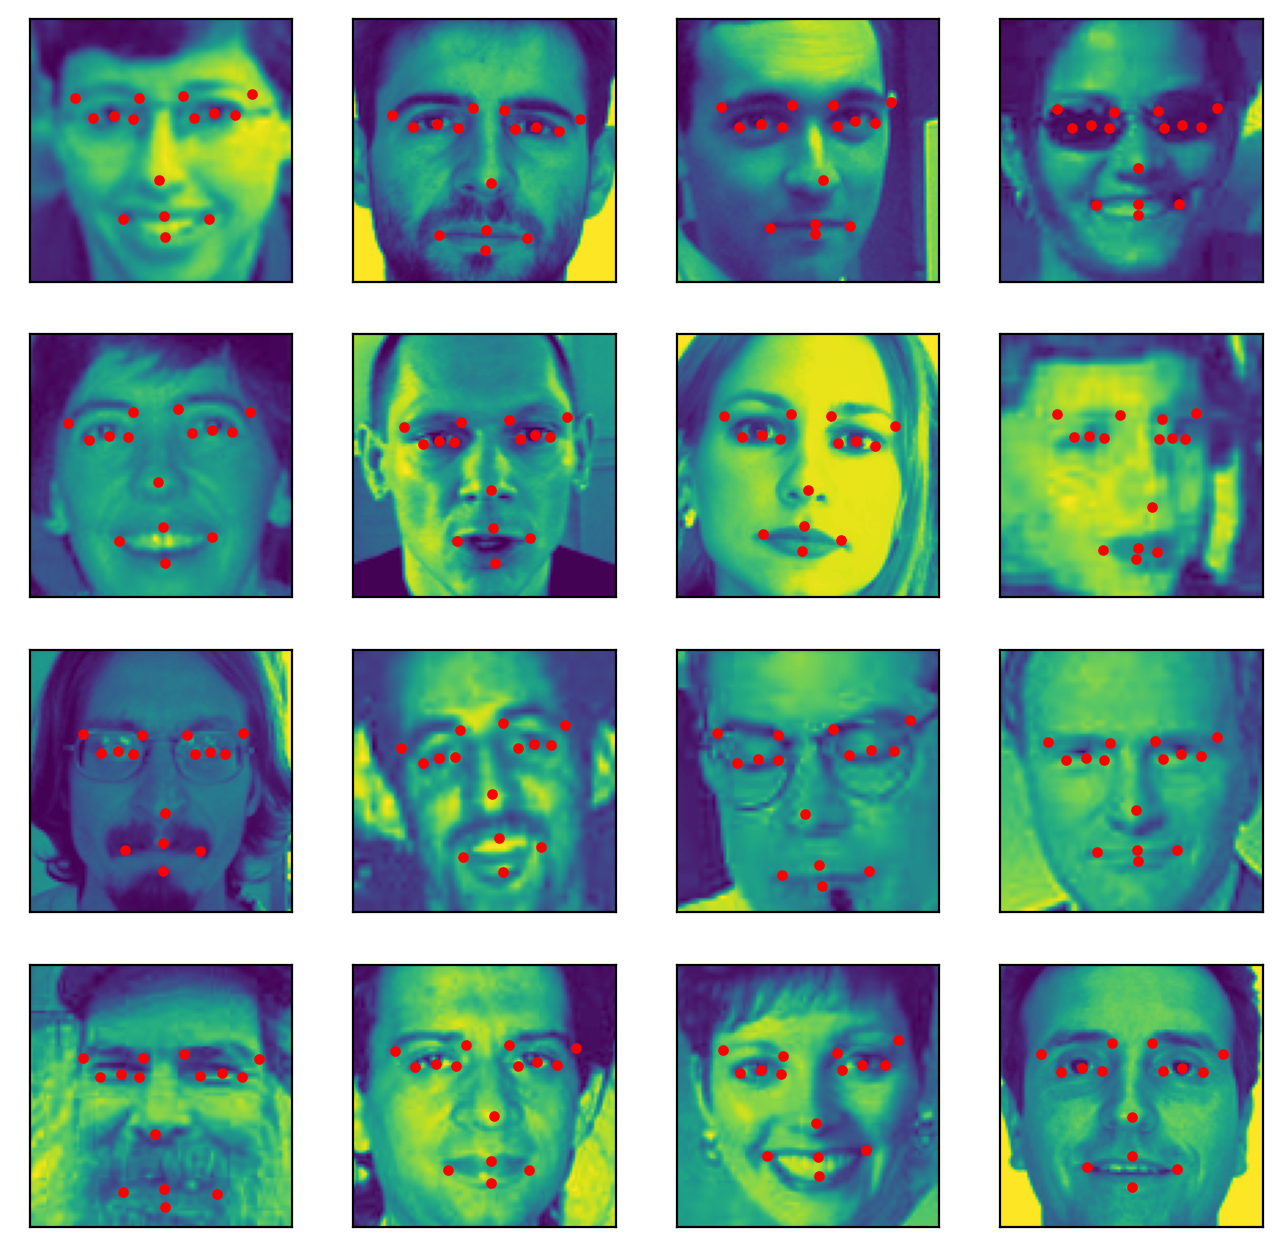

In [17]:
test_dataset = FacialKeyPointsDataset(test_data)
test_images = np.concatenate((
    test_dataset.images, test_dataset.images, test_dataset.images), axis=-1)
predicted_keypoints = model.predict(test_images)
visualize_data(test_dataset.images, predicted_keypoints)